In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your master CSV
df = pd.read_csv('6059_rows.csv')
df

,material_id,formula_pretty,crystal_system,crystal_symbol,space_group_number,poisson_ratio,bulk_voigt,bulk_hill,shear_voigt,shear_hill,youngs_modulus,debye_temperature,formula_sp
0,mp-862690,Ac,Hexagonal,P6_3/mmc,194,0.217000,24.652,24.648000,17.367,17.221000,41.915914,132.913549,Ac_194
1,mp-862786,Ac2CuGe,Cubic,Fm-3m,225,0.344000,54.864,54.864000,19.247,19.110000,51.367680,163.416460,Ac2CuGe_225
2,mp-861883,Ac2CuIr,Cubic,Fm-3m,225,0.379000,68.935,68.935000,20.551,18.099000,49.917042,143.648368,Ac2CuIr_225
3,mp-867241,Ac2GePd,Cubic,Fm-3m,225,0.364000,56.205,56.205000,17.721,16.817000,45.876776,148.604483,Ac2GePd_225
4,mp-861872,Ac2HgGe,Cubic,Fm-3m,225,0.358000,47.445,47.445000,15.117,14.917000,40.514572,132.402376,Ac2HgGe_225
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6054,mp-12552,AlNi3,NaN,NaN,221,0.296866,NaN,179.507871,NaN,95.325365,NaN,NaN,AlNi3_221
6055,mp-15322,ScSiCu,NaN,NaN,189,0.223064,NaN,113.813000,NaN,76.911000,NaN,NaN,ScSiCu_189
6056,mp-510559,Na(CoO2)2,NaN,NaN,59,0.318733,NaN,75.917411,NaN,37.647376,NaN,NaN,Na(CoO2)2_59
6057,mp-714961,Ni3O4,NaN,NaN,65,0.267000,NaN,144.151000,NaN,80.082000,NaN,NaN,Ni3O4_65


In [2]:
# 80-10-10 split
train_val, test = train_test_split(df, test_size=0.10, random_state=42)
train, val = train_test_split(train_val, test_size=0.1111, random_state=42)  # 0.1111 × 90% ≈ 10%

# Save splits
train.to_csv("train_split.csv", index=False)
val.to_csv("val_split.csv", index=False)
test.to_csv("test_split.csv", index=False)

In [3]:
import os
import shutil
import pandas as pd

def move_npy_files(split_csv, src_root, dst_root):
    df = pd.read_csv(split_csv)
    sample_names = df['formula_sp'].tolist()

    for name in sample_names:
        filename = f"{name}.npy"
        src_path = os.path.join(src_root, filename)
        dst_path = os.path.join(dst_root, filename)

        if os.path.exists(src_path):
            shutil.copy(src_path, dst_path)
        else:
            print(f"⚠️ Warning: {src_path} does not exist.")

# Paths
raw_data_dir = '/data/sai/new_charge/AUGU_13/6059_PADDED_DATA'
train_dir = '/data/sai/new_charge/AUGU_28/6059_AE_TRAIN/train/'
val_dir = '/data/sai/new_charge/AUGU_28/6059_AE_TRAIN/val/'
test_dir = '/data/sai/new_charge/AUGU_28/6059_AE_TRAIN/test/'

# Create destination dirs if they don't exist
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Move files
move_npy_files('train_split.csv', raw_data_dir, train_dir)
move_npy_files('val_split.csv', raw_data_dir, val_dir)
move_npy_files('test_split.csv', raw_data_dir, test_dir)


In [4]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence

# Custom Data Generator for autoencoder
class NPYDataGenerator(Sequence):
    def __init__(self, file_list, batch_size=4):
        self.file_list = file_list
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.file_list) / self.batch_size))

    def __getitem__(self, idx):
        batch_files = self.file_list[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_data = [np.load(f)[..., np.newaxis] for f in batch_files]  # shape (144,144,160,1)
        return np.array(batch_data), np.array(batch_data)  # X, Y same for autoencoder


2025-08-30 16:00:30.864105: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-30 16:00:30.865974: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-30 16:00:30.901523: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-30 16:00:30.901967: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-30 16:00:31.478119: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [5]:
import pandas as pd

# Paths
padded_dir_train = '/data/sai/new_charge/AUGU_28/6059_AE_TRAIN/train/'
padded_dir_val = '/data/sai/new_charge/AUGU_28/6059_AE_TRAIN/val/'

# Load splits
train_df = pd.read_csv("train_split.csv")
val_df = pd.read_csv("val_split.csv")

# Get .npy paths
file_list_train = [os.path.join(padded_dir_train, f"{folder}.npy") for folder in train_df['formula_sp']]
file_list_val = [os.path.join(padded_dir_val, f"{folder}.npy") for folder in val_df['formula_sp']]

In [6]:
len(file_list_train)

4847

In [7]:
len(file_list_val)

606

In [8]:
train_generator = NPYDataGenerator(file_list_train, batch_size=4)
val_generator = NPYDataGenerator(file_list_val, batch_size=4)

In [9]:
from tensorflow.keras import layers, models, Input

def build_autoencoder():
    input_layer = Input(shape=(128, 128, 128, 1))

    # ----- Encoder -----
    x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(input_layer)
    x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)   # 128 -> 64

    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)   # 64 -> 32

    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)   # 32 -> 16

    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling3D((2, 2, 2), padding='same')(x)   # 16 -> 8

    # Latent space: shape = (8, 8, 8, 8)
    latent = layers.Conv3D(8, (3, 3, 3), activation='relu', padding='same')(x)

    # ----- Decoder -----
    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(latent)
    x = layers.UpSampling3D((2, 2, 2))(x)  # 8 -> 16

    x = layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D((2, 2, 2))(x)  # 16 -> 32

    x = layers.Conv3D(32, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D((2, 2, 2))(x)  # 32 -> 64

    x = layers.Conv3D(16, (3, 3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling3D((2, 2, 2))(x)  # 64 -> 128

    output_layer = layers.Conv3D(1, (3, 3, 3), activation='linear', padding='same')(x)

    autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
    encoder = models.Model(inputs=input_layer, outputs=latent)

    return autoencoder, encoder


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Build and compile model
autoencoder, encoder = build_autoencoder()
autoencoder.summary()
autoencoder.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mse', 'mae']
)

# Callbacks
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',     # <<< monitor validation loss
    factor=0.7,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',     # <<< monitor validation loss
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Train with validation
history = autoencoder.fit(
    train_generator,
    validation_data=val_generator,   # <<< Add this line
    epochs=200,
    callbacks=[lr_scheduler, early_stop]
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 128,    0         
                             1)]                                 
                                                                 
 conv3d (Conv3D)             (None, 128, 128, 128, 1   448       
                             6)                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 64, 64, 64, 16)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 64, 64, 64, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 32, 32, 32, 32)    0         
 g3D)                                                        

2025-08-30 16:00:32.107527: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/200
1212/1212 [==============================] - 1018s 839ms/step - loss: 0.1165 - mse: 0.1165 - mae: 0.0999 - val_loss: 0.0359 - val_mse: 0.0359 - val_mae: 0.0631 - lr: 0.0010
Epoch 2/200
1212/1212 [==============================] - 668s 551ms/step - loss: 0.0855 - mse: 0.0855 - mae: 0.0907 - val_loss: 0.0342 - val_mse: 0.0342 - val_mae: 0.0585 - lr: 0.0010
Epoch 3/200
1212/1212 [==============================] - 649s 535ms/step - loss: 0.0430 - mse: 0.0430 - mae: 0.0666 - val_loss: 0.0220 - val_mse: 0.0220 - val_mae: 0.0543 - lr: 0.0010
Epoch 4/200
1212/1212 [==============================] - 645s 532ms/step - loss: 0.0285 - mse: 0.0285 - mae: 0.0556 - val_loss: 0.0169 - val_mse: 0.0169 - val_mae: 0.0424 - lr: 0.0010
Epoch 5/200
1212/1212 [==============================] - 640s 528ms/step - loss: 0.0221 - mse: 0.0221 - mae: 0.0492 - val_loss: 0.0193 - val_mse: 0.0193 - val_mae: 0.0583 - lr: 0.0010
Epoch 6/200
1212/1212 [==============================] - 642s 530ms/step - loss

In [11]:
# Save the full autoencoder
autoencoder.save('/data/sai/new_charge/AUGU_28/6059_AE_TRAIN/6059_autoencoder_model_128.h5')

# Save the encoder part only
encoder.save('/data/sai/new_charge/AUGU_28/6059_AE_TRAIN/6059_encoder_model_128.h5')


/home/saikumar/.venv/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt

test_dir = '/data/sai/new_charge/AUGU_28/6059_AE_TRAIN/test/'
test_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.npy')]

def evaluate_autoencoder(autoencoder, file_list):
    total_loss = 0
    all_losses = []

    for path in file_list:
        x = np.load(path)[..., np.newaxis]  
        x = np.expand_dims(x, 0)          
        x_hat = autoencoder.predict(x, verbose=0)
        loss = np.mean((x[0] - x_hat[0]) ** 2)
        all_losses.append(loss)
        total_loss += loss

    avg_loss = total_loss / len(file_list)
    print(f"Average MSE across {len(file_list)} test samples: {avg_loss:.5f}")
    return all_losses

# Run evaluation
losses = evaluate_autoencoder(autoencoder, test_files)


Average MSE across 606 test samples: 0.00278


In [13]:
def evaluate_autoencoder_mae(autoencoder, file_list):
    total_loss = 0
    all_losses = []

    for path in file_list:
        x = np.load(path)[..., np.newaxis]  
        x = np.expand_dims(x, 0)            
        x_hat = autoencoder.predict(x, verbose=0)
        loss = np.mean(np.abs(x[0] - x_hat[0]))  # MAE
        all_losses.append(loss)
        total_loss += loss

    avg_loss = total_loss / len(file_list)
    print(f"Average MAE across {len(file_list)} test samples: {avg_loss:.5f}")
    return all_losses
mae_losses = evaluate_autoencoder_mae(autoencoder, test_files)


Average MAE across 606 test samples: 0.01682


In [14]:
import os
import numpy as np
from tensorflow.keras.models import load_model

# --- Paths ---
input_dir = "/data/sai/new_charge/AUGU_28/6059_AE_TRAIN/train"
output_dir = "/data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_train"
os.makedirs(output_dir, exist_ok=True)

# --- Process each .npy file ---
file_list = sorted([f for f in os.listdir(input_dir) if f.endswith('.npy')])

for file_name in file_list:
    file_path = os.path.join(input_dir, file_name)
    
    # Load and prepare input
    x = np.load(file_path)
    if x.ndim == 3:
        x = np.expand_dims(x, axis=(0, -1))  # (1, X, Y, Z, 1)

    # Pass through encoder
    latent = encoder.predict(x)
    latent = np.squeeze(latent, axis=0)  # remove batch dimension

    # Save latent
    out_file = os.path.join(output_dir, file_name.replace(".npy", "_latent.npy"))
    np.save(out_file, latent)
    
    print(f"[✓] Saved latent: {out_file}")


1/1 [==============================] - 0s 107ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_train/Ac2CuGe_225_latent.npy
1/1 [==============================] - 0s 51ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_train/Ac2CuIr_225_latent.npy
1/1 [==============================] - 0s 49ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_train/Ac2GePd_225_latent.npy
1/1 [==============================] - 0s 49ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_train/Ac2IrAu_225_latent.npy
1/1 [==============================] - 0s 49ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_train/Ac2IrPd_225_latent.npy
1/1 [==============================] - 0s 50ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_train/Ac2MgSn_225_latent.npy
1/1 [==============================] - 0s 49ms/step
[✓] Saved latent: /data/sai/n

In [15]:
from tensorflow.keras.models import load_model


In [16]:
# Save the full autoencoder
autoencoder= load_model('/data/sai/new_charge/AUGU_28/6059_AE_TRAIN/6059_autoencoder_model_128.h5')

# Save the encoder part only
encoder= load_model('/data/sai/new_charge/AUGU_28/6059_AE_TRAIN/6059_encoder_model_128.h5')


In [17]:
import os
import numpy as np
from tensorflow.keras.models import load_model

# --- Paths ---
input_dir = "/data/sai/new_charge/AUGU_28/6059_AE_TRAIN/test"
output_dir = "/data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_test"
os.makedirs(output_dir, exist_ok=True)

# --- Process each .npy file ---
file_list = sorted([f for f in os.listdir(input_dir) if f.endswith('.npy')])

for file_name in file_list:
    file_path = os.path.join(input_dir, file_name)
    
    
    
    
    
    
    
    # Load and prepare input
    x = np.load(file_path)
    if x.ndim == 3:
        x = np.expand_dims(x, axis=(0, -1))  # (1, X, Y, Z, 1)

    # Pass through encoder
    latent = encoder.predict(x)
    latent = np.squeeze(latent, axis=0)  # remove batch dimension

    # Save latent
    out_file = os.path.join(output_dir, file_name.replace(".npy", "_latent.npy"))
    np.save(out_file, latent)
    
    print(f"[✓] Saved latent: {out_file}")


1/1 [==============================] - 0s 105ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_test/Ac2NiIr_225_latent.npy
1/1 [==============================] - 0s 53ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_test/AcAu3_194_latent.npy
1/1 [==============================] - 0s 48ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_test/AcBr3_176_latent.npy
1/1 [==============================] - 0s 49ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_test/AcCl3_176_latent.npy
1/1 [==============================] - 0s 48ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_test/AcHg3_194_latent.npy
1/1 [==============================] - 0s 48ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_test/AcPbAu2_225_latent.npy
1/1 [==============================] - 0s 52ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU

In [18]:
import os
import numpy as np
from tensorflow.keras.models import load_model

# --- Paths ---
input_dir = "/data/sai/new_charge/AUGU_28/6059_AE_TRAIN/val"
output_dir = "/data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_val"
os.makedirs(output_dir, exist_ok=True)

# --- Process each .npy file ---
file_list = sorted([f for f in os.listdir(input_dir) if f.endswith('.npy')])

for file_name in file_list:
    file_path = os.path.join(input_dir, file_name)
    
    
    
    
    
    
    
    # Load and prepare input
    x = np.load(file_path)
    if x.ndim == 3:
        x = np.expand_dims(x, axis=(0, -1))  # (1, X, Y, Z, 1)

    # Pass through encoder
    latent = encoder.predict(x)
    latent = np.squeeze(latent, axis=0)  # remove batch dimension

    # Save latent
    out_file = os.path.join(output_dir, file_name.replace(".npy", "_latent.npy"))
    np.save(out_file, latent)
    
    print(f"[✓] Saved latent: {out_file}")


1/1 [==============================] - 0s 55ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_val/Ac2HgGe_225_latent.npy
1/1 [==============================] - 0s 55ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_val/AcCuO3_221_latent.npy
1/1 [==============================] - 0s 59ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_val/AcH3_225_latent.npy
1/1 [==============================] - 0s 56ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_val/AgBr_225_latent.npy
1/1 [==============================] - 0s 56ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_val/AgClO4_121_latent.npy
1/1 [==============================] - 0s 57ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/6059_AE_TRAIN/latent_128_val/Al(CrB)2_65_latent.npy
1/1 [==============================] - 0s 54ms/step
[✓] Saved latent: /data/sai/new_charge/AUGU_28/605

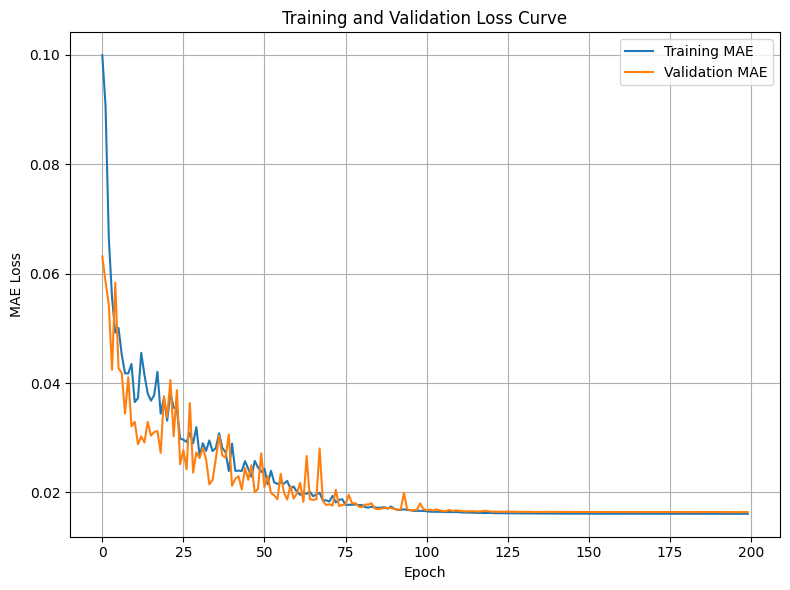

In [19]:

import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(8, 6))
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
